In [1]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
import io
import pickle
import numpy as np
import pandas as pd
import os
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from collections import defaultdict
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import matplotlib

In [2]:
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['font.serif'] = ['Times New Roman']

In [3]:
os.chdir('..')

In [4]:
gauth = GoogleAuth()
gauth.DEFAULT_SETTINGS['client_config_file'] = 'client_secret_1057507276332-5mk9ac9q22rsmtm1idlqvpraq08ar8p5.apps.googleusercontent.com.json'
gauth.LoadCredentialsFile("mycreds.txt")
if gauth.credentials is None:
    gauth.LocalWebserverAuth()
elif gauth.access_token_expired:
    gauth.Refresh()
else:
    gauth.Authorize()

gauth.SaveCredentialsFile("mycreds.txt")
drive = GoogleDrive(gauth)

In [5]:
max_games = 500000 
asset_dir = 'asset'
file_name = '2023_tc_50000_games.pgn'

cached_urls_file = file_name.split('.')[0] + '_urls_list.pkl'
cached_ratings_file = file_name.split('.')[0] + '_ratings_list.pkl'
cached_games_file = file_name.split('.')[0] + '_game_arrays.pkl'

In [6]:
def load_item_from_file(file_path):
    if os.path.exists(file_path):
        print('loading item from cache...')
        with open(file_path, 'rb') as file:
            items = pickle.load(file)
        print('loaded')
        return items
    else:
        return None

try:
    assets_path = os.path.join(os.getcwd(), asset_dir)
    cached_urls_path = os.path.join(assets_path, cached_urls_file)
    cached_ratings_path = os.path.join(assets_path, cached_ratings_file)
    cached_games_path = os.path.join(assets_path, cached_games_file)
    urls_list = load_item_from_file(cached_urls_path)
    ratings_list = load_item_from_file(cached_ratings_path)
    game_arrays = load_item_from_file(cached_games_path)
except:
    print('Files not on disk, reading from drive...')
    urls_list = None
    ratings_list = None
    game_arrays = None

loading item from cache...
loaded
loading item from cache...
loaded
loading item from cache...
loaded


In [7]:
def find_folder_id(folder_name):
    """Find and return the Google Drive folder ID for a given folder name."""
    file_list = drive.ListFile({'q': f"title='{folder_name}' and mimeType='application/vnd.google-apps.folder' and trashed=false"}).GetList()
    for file in file_list:
        if file['title'] == folder_name:
            return file['id']
    return None

def read_pkl_file_from_drive(file_title, parent_id):
    """Read a .pkl file directly from Google Drive into a Python object."""
    query = f"'{parent_id}' in parents and trashed=false and title='{file_title}'"
    file_list = drive.ListFile({'q': query}).GetList()
    if not file_list:
        print(f"No file found with title: {file_title}")
        return None
    file = file_list[0]
    file_content = file.GetContentString(encoding='cp437')
    buffer = io.BytesIO(file_content.encode('cp437'))
    return pickle.load(buffer)

asset_folder_id = find_folder_id(asset_dir)
if asset_folder_id is None:
    print("Asset folder not found.")
elif game_arrays is not None:
    pass
else:
    file_titles = {
        'urls_list': cached_urls_file,
        'ratings_list': cached_ratings_file,
        'game_arrays': cached_games_file,
    }

    urls_list = read_pkl_file_from_drive(file_titles['urls_list'], asset_folder_id)
    ratings_list = read_pkl_file_from_drive(file_titles['ratings_list'], asset_folder_id)
    game_arrays = read_pkl_file_from_drive(file_titles['game_arrays'], asset_folder_id)

if urls_list is not None:
    print("URLs list loaded successfully.")
if ratings_list is not None:
    print("Ratings list loaded successfully.")
if game_arrays is not None:
    print("Game arrays loaded successfully.")

##2m 26.4s

URLs list loaded successfully.
Ratings list loaded successfully.
Game arrays loaded successfully.


In [8]:
features = ['ply_count', 'count_legal_moves', 'force_moves_percent', 'game_state',
            'distance', 'is_endgame', 'has_increment', 'in_time_trouble',
            'can_dirty_flag', 'is_check', 'is_double_check', 'is_discovered_check',
            'is_capture', 'is_threat', 'is_developing', 'is_retreating',
            'was_hanging', 'is_hanging', 'was_true_hanging', 'is_true_hanging',
            'is_create_tension', 'is_resolve_tension', 'is_maintain_tension',
            'is_reacting', 'is_same_piece', 'veni_vidi_vici', 'is_collinear',
            'moved_piece_king', 'moved_piece_queen', 'moved_piece_rook',
            'moved_piece_bishop', 'moved_piece_knight', 'moved_piece_pawn',
            'time_category_instant', 'time_category_fast', 'time_category_normal',
            'time_category_slow', 'classification_name_Great',
            'classification_name_Good', 'classification_name_Inaccuracy',
            'classification_name_Blunder', 'classification_name_Mistake']

In [9]:
def train_test_split_5(game_arrays, ratings_list, urls_list, fold_number=0):
    if fold_number < 0 or fold_number > 4:
        raise ValueError("fold_number must be between 0 and 4")
    game_vecs = [np.mean(matrix, axis=0) for matrix in game_arrays]
    X_test = game_vecs[fold_number::5]
    X_train = [df for i in range(5) if i != fold_number for df in game_vecs[i::5]]
    y_test = ratings_list[fold_number::5]
    y_train = [ratings for i in range(5) if i != fold_number for ratings in ratings_list[i::5]]
    test_urls = urls_list[fold_number::5]
    train_urls = [url for i in range(5) if i != fold_number for url in urls_list[i::5]]

    return X_train, X_test, y_train, y_test, train_urls, test_urls

In [10]:
them_preds_nb = []
them_tests_nb = []
for fold in range(5):
    X_train, X_test, y_train, y_test, train_urls, test_urls = train_test_split_5(game_arrays, ratings_list, urls_list, fold)
    clf_nb = BernoulliNB().fit(X_train, y_train)
    y_pred_nb = clf_nb.predict(X_test)
    them_preds_nb.append(y_pred_nb)
    them_tests_nb.append(y_test)

In [11]:
them_preds_lr = []
them_tests_lr = []
ps = []
for fold in range(5):
    X_train, X_test, y_train, y_test, train_urls, test_urls = train_test_split_5(game_arrays, ratings_list, urls_list, fold)
    clf_lr = LinearRegression().fit(X_train, y_train)
    y_pred_lr = clf_lr.predict(X_test)
    y_preds_lr = np.round(np.array(y_pred_lr))
    y_preds_lr[y_preds_lr > 9] = 9
    y_preds_lr[y_preds_lr < 0] = 0
    ps.append([sum(abs(p - a) <= k for p, a in zip(y_preds_lr, y_test))/len(y_test) for k in range(10)])
    them_preds_lr.append(y_preds_lr)
    them_tests_lr.append(y_test)

In [12]:
np.mean(np.array(ps), axis=0)

array([0.20191, 0.5546 , 0.81089, 0.94014, 0.98595, 0.99699, 0.99941,
       0.99985, 0.99997, 1.     ])

In [13]:
game_vecs = [np.mean(matrix, axis=0) for matrix in game_arrays]
model = LinearRegression().fit(game_vecs, ratings_list)
model.coef_, features
feature_importances = model.coef_
feature_importance_pairs = zip(features, feature_importances)
sorted_feature_importances = sorted(feature_importance_pairs, key=lambda x: x[1], reverse=True)
top_features = sorted_feature_importances[:10]
bottom_features = sorted_feature_importances[::-1][15:25]
top_features, bottom_features

([('count_legal_moves', 17.111346746638155),
  ('force_moves_percent', 9.599118636192822),
  ('was_hanging', 6.373069659020521),
  ('is_resolve_tension', 5.9524796754974325),
  ('is_hanging', 5.320269459426423),
  ('is_create_tension', 4.757345598583531),
  ('is_retreating', 3.8906325731203677),
  ('distance', 2.104520705806117),
  ('in_time_trouble', 1.876900194251524),
  ('is_developing', 1.328004675127798)],
 [('ply_count', -79.1129606840231),
  ('is_discovered_check', -12.90410593167341),
  ('is_true_hanging', -11.027813757003507),
  ('is_capture', -6.49225056001899),
  ('game_state', -5.428643317891075),
  ('is_check', -5.216160247146571),
  ('is_same_piece', -5.198137401502621),
  ('veni_vidi_vici', -4.229601235628896),
  ('was_true_hanging', -3.6542762907332067),
  ('can_dirty_flag', -2.7471976925786907)])

In [14]:
[round(i,4) for i in np.std(np.array(ps), axis=0)]

[0.0033, 0.003, 0.0026, 0.0007, 0.0004, 0.0001, 0.0001, 0.0, 0.0, 0.0]

In [15]:
%%time
random_forest_preds = 'rf10p.pkl'
random_forest_tests = 'rf10t.pkl'
random_forest_fimps = 'rf10f.pkl'
folds = 5
them_preds_rf = None
them_tests_rf = None
them_fimps_rf = None

try:
    with open(random_forest_preds, 'rb') as file:
        them_preds_rf = pickle.load(file)
    with open(random_forest_tests, 'rb') as file:
        them_tests_rf = pickle.load(file)
    with open(random_forest_fimps, 'rb') as file:
        them_fimps_rf = pickle.load(file)
    print("Successfully loaded RF configurations!")
except:
    print("RF configurations not found, simulating random forests...")
    them_preds_rf = []
    them_tests_rf = []
    them_fimps_rf = []
    for i in range(folds):
        X_train, X_test, y_train, y_test, train_urls, test_urls = train_test_split_5(game_arrays, ratings_list, urls_list, i)
        clf_rf = RandomForestClassifier(n_estimators=1000, n_jobs=-1)
        clf_rf.fit(X_train, y_train)
        y_pred_rf = clf_rf.predict(X_test)
        feat_imps = clf_rf.feature_importances_
        them_preds_rf.append(y_pred_rf)
        them_tests_rf.append(y_test)
        them_fimps_rf.append(feat_imps)
        print(f"Fold {i+1}/{folds} Complete")
    with open(random_forest_preds, 'wb') as file:
        pickle.dump(np.array(them_preds_rf), file)
    with open(random_forest_tests, 'wb') as file:
        pickle.dump(np.array(them_tests_rf), file)
    with open(random_forest_fimps, 'wb') as file:
        pickle.dump(np.array(them_fimps_rf), file)

#CPU times: total: 2h 2min 19s
#Wall time: 17min 14s

Successfully loaded RF configurations!
CPU times: total: 0 ns
Wall time: 25 ms


In [16]:
feature_importances = np.mean(them_fimps_rf, axis=0)
feature_important_std = np.std(them_fimps_rf, axis=0)

feature_importance_pairs = zip(features, feature_importances)
sorted_feature_importances = sorted(feature_importance_pairs, key=lambda x: x[1], reverse=True)

feature_volatility_pairs = zip(features, feature_important_std)
sorted_feature_volatility = sorted(feature_volatility_pairs, key=lambda x: x[1], reverse=True)

top_features = sorted_feature_importances[:10]
top_volatile_features = sorted_feature_volatility[:10]
print(top_volatile_features)
top_features

[('is_maintain_tension', 0.00010369232874158641), ('is_reacting', 9.969722747579003e-05), ('time_category_instant', 9.807792318761795e-05), ('is_capture', 9.327331289834574e-05), ('classification_name_Good', 9.106301999377923e-05), ('is_check', 9.104839925033624e-05), ('count_legal_moves', 7.95008190429431e-05), ('is_same_piece', 7.697219258908278e-05), ('game_state', 7.120363086620406e-05), ('in_time_trouble', 6.024728122095089e-05)]


[('classification_name_Blunder', 0.03559832553848682),
 ('classification_name_Great', 0.03432198437240011),
 ('time_category_instant', 0.031950503377773457),
 ('game_state', 0.03162949652610341),
 ('time_category_normal', 0.03130983895788779),
 ('count_legal_moves', 0.030878494653012612),
 ('is_capture', 0.029512137947886746),
 ('is_same_piece', 0.029468680314415584),
 ('veni_vidi_vici', 0.029231593370952196),
 ('time_category_fast', 0.028278349943468523)]

In [17]:
def pad_game(game, max_length=256, vector_size=42):
    padding_length = max_length - len(game)
    if padding_length < 0:
        return game[:max_length]
    else:
        padding = np.full((padding_length, vector_size), -1)
        return np.vstack((game, padding))

In [18]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout_rate=0):
        super(RNN, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, hidden_size)
        self.fc5 = nn.Linear(hidden_size, hidden_size)
        self.fc6 = nn.Linear(hidden_size, hidden_size)
        self.fc7 = nn.Linear(hidden_size, hidden_size)
        self.fc_classification = nn.Linear(hidden_size, num_classes)
        self.fc_regression = nn.Linear(hidden_size, 1)
        self.dropout = nn.Dropout(dropout_rate)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 

        out, _ = self.lstm(x, (h0,c0))  
        out = out[:, -1, :]
        
        out = self.dropout(F.relu(self.fc1(out)))
        out = self.dropout(F.relu(self.fc2(out)))
        out = self.dropout(F.relu(self.fc3(out)))
        out = self.dropout(F.relu(self.fc4(out)))
        out = self.dropout(F.relu(self.fc5(out)))
        out = self.dropout(F.relu(self.fc6(out)))
        out = self.dropout(F.relu(self.fc7(out)))
        classification_output = self.fc_classification(out)
        regression_output = self.fc_regression(out)
        return classification_output, regression_output

In [19]:
def get_loaders(padded_games, ratings_list, urls_list, batch_size, fold_number=0):
    if fold_number < 0 or fold_number > 4:
        raise ValueError("fold_number must be between 0 and 4")
    test_list = padded_games[fold_number::5]
    train_list = [df for i in range(5) if i != fold_number for df in padded_games[i::5]]
    test_ratings = ratings_list[fold_number::5]
    train_ratings = [ratings for i in range(5) if i != fold_number for ratings in ratings_list[i::5]]
    test_urls = urls_list[fold_number::5]
    train_urls = [url for i in range(5) if i != fold_number for url in urls_list[i::5]]

    train_data = [torch.FloatTensor(doc) for doc in train_list]
    test_data = [torch.FloatTensor(doc) for doc in test_list]
    train_labels = torch.LongTensor(train_ratings)
    test_labels = torch.LongTensor(test_ratings)

    train_dataset = TensorDataset(torch.stack(train_data), train_labels)
    test_dataset = TensorDataset(torch.stack(test_data), test_labels)
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader, train_urls, test_urls

In [20]:
def combined_loss(classification_output, regression_output, target, alpha=0.5):
    classification_loss = nn.CrossEntropyLoss()(classification_output, target)
    regression_target = target.float()
    regression_loss = nn.MSELoss()(regression_output.squeeze(), regression_target)
    return alpha * classification_loss + (1 - alpha) * regression_loss

def train_model(model, train_loader, test_loader, optimizer, num_epochs, device, alpha=0.5):
    torets = []
    for epoch in range(num_epochs):
        model.train()
        for i, (moves, labels) in enumerate(train_loader):  
            moves = moves.to(device)
            labels = labels.to(device)

            classification_output, regression_output = model(moves)
            loss = combined_loss(classification_output, regression_output, labels, alpha)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        #print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')
        predicted_probs, predicted_labels, actual_labels = test_model(model, test_loader, device)
        pred_closeness = [sum(abs(p - a) <= k for p, a in zip(predicted_labels, actual_labels)) for k in range(10)]
        toret = [x/20000 for x in pred_closeness]
        torets.append(toret)
    return torets

def test_model(model, test_loader, device):
    model.eval()
    n_correct = 0
    n_samples = 0
    predicted_probs = []
    predicted_labels = []
    actual_labels = []
    with torch.no_grad():
        for moves, labels in test_loader:
            moves = moves.to(device)
            labels = labels.to(device)
            classification_output, _ = model(moves)
            probabilities = F.softmax(classification_output, dim=1)

            _, predicted = torch.max(classification_output.data, 1)
            predicted_probs.extend(probabilities.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())
            actual_labels.extend(labels.cpu().numpy())
            n_samples += labels.size(0)
            n_correct += (predicted == labels).sum().item()

    acc = 100.0 * n_correct / n_samples
    #print(f'Accuracy of the network on the test moves: {acc} %')
    return predicted_probs, predicted_labels, actual_labels

In [21]:
input_size = 42
num_classes = 10
num_epochs = 40
sequence_length = 128
batch_size = 100
hidden_size = 100
num_layers = 3
learning_rate = 0.0008
alpha = 0.9
dropout_rate = 0
decay = 0.0001

torch.manual_seed(64)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_path = file_name.split('.')[0] + '_pred.pth'
model = RNN(input_size, hidden_size, num_layers, num_classes, dropout_rate).to(device)
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'The model has {num_params:,} trainable parameters')

def train_lstm():
    padded_games = [pad_game(g, sequence_length) for g in game_arrays]
    lstm_preds = []
    lstm_truths = []
    for fold in range(5):
        print(f"Training Epoch {fold+1}/5 ...")
        train_loader, test_loader, train_urls, test_urls = get_loaders(padded_games, ratings_list, urls_list, batch_size, fold)
        model = RNN(input_size, hidden_size, num_layers, num_classes, dropout_rate).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=decay)
        num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        lists = train_model(model, train_loader, test_loader, optimizer, num_epochs, device, alpha)
        predicted_probs, predicted_labels, actual_labels = test_model(model, test_loader, device)

        lstm_preds.append(predicted_labels)
        lstm_truths.append(actual_labels)
    return lstm_preds, lstm_truths

The model has 291,011 trainable parameters


In [22]:
lstm_preds_path = 'lstm_fold_preds.pkl'
lstm_truths_path = 'lstm_fold_truths.pkl'

try:
    with open(lstm_preds_path, 'rb') as file:
        lstm_preds = pickle.load(file)
    with open(lstm_truths_path, 'rb') as file:
        lstm_truths = pickle.load(file)
    print("Successfully loaded LSTM configurations!")

except:
    lstm_preds, lstm_truths = train_lstm()
    with open(lstm_preds_path, 'wb') as file:
        pickle.dump(np.array(lstm_preds), file)
    with open(lstm_truths_path, 'wb') as file:
        pickle.dump(np.array(lstm_truths), file)

Successfully loaded LSTM configurations!


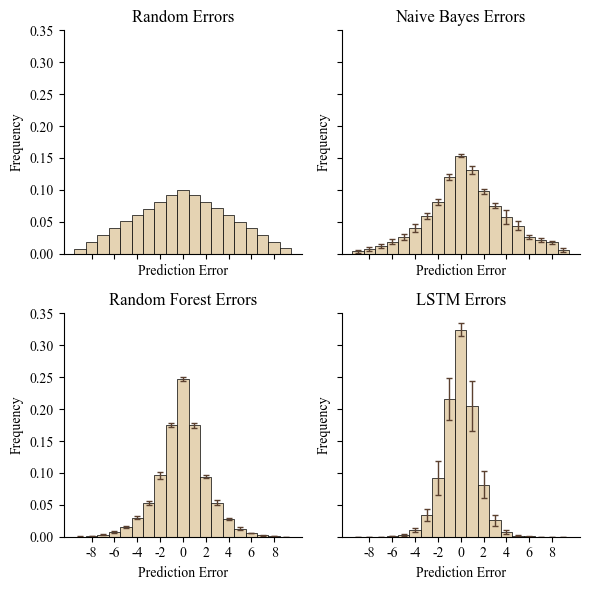

In [23]:
def pred_and_truth_to_dict(diffs, accums):
    errordict = defaultdict(float)
    for diff, accum in zip(diffs, accums):
        errordict[diff] += accum
    categories = range(-9, 10)
    errordict = {n: errordict[n] for n in categories}
    frequencies = list(errordict.values())
    return frequencies

def plot_errors(ax, frequencies, title, std_dev=None):
    categories = list(range(-9, 10, 1))
    ax.bar(categories, frequencies, width=1, color='#e5d3b3', edgecolor='black', linewidth=0.5) 
    ax.set_xlabel('Prediction Error')
    ax.set_ylabel('Frequency')
    ax.set_title(title)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticks(range(-8, 9, 2))
    ax.set_xticklabels(range(-8, 9, 2))
    ax.set_ylim(bottom=0, top=0.35)

    if std_dev is not None:
        n = np.array(frequencies)
        n[n == 0] = np.nan
        ci_95 = 1.96 * np.array(std_dev) #math checks out
        ax.errorbar(categories, frequencies, yerr=ci_95, fmt='none', ecolor='#5b402f', capsize=2, elinewidth=1)

def pred_and_test_mat_to_freqs(them_preds, them_tests):
    length = 20000
    increments = [1/length]*length
    n_by_error_l = []
    for i in range(len(them_preds)):
        y_pred = them_preds[i]
        y_test = them_tests[i]
        increments = [1/2e4]*length
        edict = [p-a for p, a in zip(y_pred, y_test)]
        n_by_error = pred_and_truth_to_dict(edict, increments)
        n_by_error_l.append(n_by_error)
    frequencies = np.mean(np.array(n_by_error_l), axis=0)
    standard_errors = np.std(np.array(n_by_error_l), axis=0)
    return frequencies, standard_errors

fig, axs = plt.subplots(2, 2, figsize=(6, 6), sharex='col', sharey='all')

labels = pd.Series(ratings_list).value_counts().index.tolist()
counts = pd.Series(ratings_list).value_counts().values.tolist()
diffs = [i-label for i in range(10) for label in labels]
accums = [count/1e6 for _ in range(10) for count in counts]
frequencies_re = pred_and_truth_to_dict(diffs, accums)
plot_errors(axs[0, 0], frequencies_re, 'Random Errors')

frequencies_nb, standard_errors_nb = pred_and_test_mat_to_freqs(them_preds_nb, them_tests_nb)
plot_errors(axs[0, 1], frequencies_nb, 'Naive Bayes Errors', standard_errors_nb)

frequencies_rf, standard_errors_rf = pred_and_test_mat_to_freqs(them_preds_rf, them_tests_rf)
plot_errors(axs[1, 0], frequencies_rf, 'Random Forest Errors', standard_errors_rf)

frequencies_lstm, standard_errors_lstm = pred_and_test_mat_to_freqs(lstm_preds, lstm_truths)
plot_errors(axs[1, 1], frequencies_lstm, 'LSTM Errors', standard_errors_lstm)

plt.tight_layout()
plt.show()

In [24]:
standard_errors_nb[9], standard_errors_rf[9], standard_errors_lstm[9]

(0.0012675172582650093, 0.001708039812182186, 0.00521587959983683)

In [25]:
for f in [frequencies_re, frequencies_nb, frequencies_rf, frequencies_lstm]:
    accuracies = [0]*10
    for p, i in zip(f, range(-9, 10, 1)):
        accuracies[abs(i)] += p
    accs = [round(20000*sum(accuracies[:i+1])) for i in range(len(accuracies))]
    print([round(i/200, 2) for i in accs])

[10.0, 28.38, 44.63, 58.8, 70.88, 80.88, 88.81, 94.64, 98.38, 100.0]
[15.34, 40.42, 58.34, 71.8, 81.56, 88.59, 93.16, 96.54, 99.0, 100.0]
[24.7, 59.75, 78.79, 89.41, 95.06, 97.86, 99.2, 99.73, 99.97, 100.0]
[32.41, 74.4, 91.77, 97.69, 99.44, 99.86, 99.97, 100.0, 100.0, 100.0]
